# 第二章 关键字搜索


在本章中，您将学习如何使用关键词搜索并利用数据库回答问题。搜索对于我们在世界中导航非常关键。它包括搜索引擎，也包括在应用程序内部进行搜索，比如在 Spotify、YouTube 或 Google 地图中进行搜索。公司和组织也需要使用关键词搜索或其他各种搜索方法来搜索其内部文件。关键词搜索是构建搜索系统最常用的方法。接下来，让我们看看如何使用关键词搜索系统，然后再看看语言模型如何改进这些系统。

在本章教程中，我们需要用到 Weaviate 和 Cohere 的 API key。

让我们先准备好需要用到的一些 python 库和 API：

In [ ]:
!pip install cohere
!pip install weaviate-client
!pip install python-dotenv

In [ ]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # 读取本地 .env 文件

## 一、Weaviate 数据库

Weaviate是一个开源数据库。它具有关键字搜索功能，也具有依赖于语言模型的向量搜索功能。

### 1.1 进行身份验证配置

In [ ]:
import weaviate
auth_config = weaviate.auth.AuthApiKey(
    api_key=os.environ['WEAVIATE_API_KEY'])  # 获取环境变量中的Weaviate API密钥，进行身份验证。

现在，我们已经设置了身份验证的配置，让我们看一下如何将客户端连接到实际数据库

### 1.2 连接数据库

+ weaviate.Client() ：Weaviate客户端对象。

+ url ：Weaviate客户端的URL属性。这个URL指定了与Weaviate服务进行通信的位置。

+ auth_client_secret ：Weaviate客户端的身份验证密钥属性

+ additional_headers ：额外的请求头信息。

In [ ]:
client = weaviate.Client(
    url=os.environ['WEAVIATE_API_URL'],  
    auth_client_secret=auth_config,
    additional_headers={
        "X-Cohere-Api-Key": os.environ['COHERE_API_KEY'],  # 这里添加了一个名为X-Cohere-Api-Key的请求头，其值为环境变量中的Cohere API密钥。
    }
)

这个数据库是一个公共数据库，包含了1000万条记录。这些记录来自维基百科。每个单元格、每个记录、每一行都是来自维基百科的一个段落。
这1000万条记录来自10种不同的语言。其中100万条是英文的，其余900万条是其他语言的。我们可以选择和过滤我们想要查询的语言，这个我们稍后会学到。

运行下面这行代码后，我们确保客户端已经准备好并连接上了。如果返回 True，那就意味着我们的本地 Weaviate 客户端能够连接到远程 Weaviate 数据库。然后我们就能在这个数据集上进行关键词搜索了。

In [ ]:
client.is_ready() 

## 二、关键字搜索

让我们先简单了解一下关键词搜索。

假设您有一个查询："草是什么颜色？"，并且您在一个非常小的文档集中进行搜索，其中包含了以下五个句子：“明天是星期六”，“草是绿色的”，“加拿大的首都是渥太华”，“天空是蓝色的”，“鲸鱼是哺乳动物”。

这是一个简单的搜索示例。关键词搜索的工作原理是比较**查询**和**文档**之间有多少共同的单词。如果我们比较查询和第一句话之间有多少共同的单词，它们只有一个共同的单词："is"。因此，它们只有一个共同的单词。

我们可以看到这个文档集中每个句子的计数情况。然后我们可以发现第二个句子与查询有最多的共同单词，因此关键词搜索可能会将其作为答案返回。

下面我们开始学习如何使用关键字搜索。


### 2.1 构建关键字搜索函数

在之前的代码中我们已经连接到数据库，现在让我们构建一个查询数据库的函数。我们将其称为"keyword_search"。

我们需要先明确添加的集合的类型，这里需要添加的集合被称为 Articles ，它在数据库中有定义。并且这个数据库中的每篇文章都有许多属性。对于这个搜索，我们希望输入一个查询时，能够返回每个结果的标题、URL和正文。这里还有其他属性，但现在我们不希望数据库将它们返回给我们。

接下来处理关键词搜索部分，我们需要输入".with_bm25"，bm25 是一种常用的关键词搜索或词汇搜索算法，它根据一个特定的公式对存档中的文档与查询进行评分，该公式考虑了查询与每个文档之间共享单词的数量。我们在这里需要将查询传递给 query 参数，即输入"query=query"。

还有几行代码我们需要传递给".with_where"，这样我们就可以在特定格式下使用 where 子句。如果我们想要做的是将结果限制为仅包含英文结果，那么结果语言也是我们要添加到这个定义中的内容。

我们需要添加的另一行是".with_limit"。它可以决定我们希望搜索引擎将多少条结果返回给我们。这里我们将"num_results"设置为3，即我们默认返回3条结果。

有了这些，我们的查询就完成了。现在函数可以获取响应并返回结果。这就是我们的关键词搜索函数。

In [ ]:
def keyword_search(query,
                   results_lang='en',
                   properties = ["title","url","text"],
                   num_results=3):

    where_filter = {
    "path": ["lang"],
    "operator": "Equal",
    "valueString": results_lang
    }
    
    response = (
        client.query.get("Articles", properties)
        .with_bm25(
            query=query
        )
        .with_where(where_filter)
        .with_limit(num_results)
        .do()
        )

    result = response['data']['Get']['Articles']
    return result

### 2.2 使用关键字搜索函数

现在让我们使用这个关键词搜索函数，并传递一个查询给它。
假设我们说，"What is the most viewed televised event?"，即"什么是观看次数最多的电视事件？"

我们将查询传递给函数，然后将其打印出来，看看运行后会返回什么。

In [ ]:
query = "What is the most viewed televised event?"
keyword_search_results = keyword_search(query)
print(keyword_search_results)

[{'text': 'The most active Gamergate supporters or "Gamergaters" said that Gamergate was a movement for ethics in games journalism, for protecting the "gamer" identity, and for opposing "political correctness" in video games and that any harassment of women was done by others not affiliated with Gamergate. They argued that the close relationships between journalists and developers demonstrated a conspiracy among reviewers to focus on progressive social issues. Some supporters pointed to what they considered disproportionate praise for games such as "Depression Quest" and "Gone Home", which feature unconventional gameplay and stories with social implications, while they viewed traditional AAA games as downplayed. False claims of the "ethics in game journalism" had started as early as 2012, when Geoff Keighley was accused of such unethical behavior when he was presenting information about "Halo 4" among advertisements for Mountain Dew and Doritos, an event called "Doritosgate" in the gamer culture.', 'title': 'Gamergate (harassment campaign)', 'url': 'https://en.wikipedia.org/wiki?curid=43758363'}, {'text': '"Rolling Stone" stated Jackson\'s Super Bowl performance "is far and away the most famous moment in the history of the Super Bowl halftime show". "PopCrush" called the performance "one of the most shocking moments in pop culture" as well as a "totally unexpected and unforgettable moment". "Gawker" ranked the performance among the most recent of the "10 Shows that Advanced Sex on Television", commenting the set "had all the elements of a huge story" and "within seconds the world searched furtively for pictures", concluding "it remains so ubiquitous, it\'s impossible to look at a starburst nipple shield without thinking "Janet Jackson"". "E! Online" ranked it among the top ten most shocking celebrity moments of the prior two decades. A study of television\'s most impactful moments of the last 50 years conducted by Sony Electronics and the Nielsen Television Research Company ranked Jackson\'s Super Bowl performance at #26. The incident was the only Super Bowl event on the list and the highest music and entertainment event aside from the death of Whitney Houston. TV Guide Network ranked it at #2 in a 2010 special listing the "25 Biggest TV Blunders". "Complex" stated "It\'s the Citizen Kane of televised nip-slips—so unexpected, and on such a large stage, that nothing else will ever come close. If Beyoncé were to whip out both breasts and put on a puppet show with them when she performs this year in New Orleans, it would rate as just the second most shocking Super Boob display. Janet\'s strangely ornamented right nipple is a living legend, and so is Justin Timberlake\'s terrified reaction." Music channel Fuse listed it as the most controversial Super Bowl halftime show, saying the "revealing performance remains (and will forever remain) the craziest thing to ever happen at a halftime show. Almost immediately after the incident, the FCC received a flood of complaints from parents who just wanted their children to enjoy a nice, wholesome three hours of grown men inflicting damaging and long-lasting pain on each other for sport. Halftime shows would never be the same." Patrick Gipson of "Bleacher Report" ranked it as #1 in its list of the most "Jaw Dropping Moments of the Last Decade", stating Janet "changed the landscape of live television forever". Gipson explained "It prompted a million mothers to cover their eyes, fathers and sons to jump out of their seats in shock and numerous sanctions by the Federal Communications Commission, including a US$550,000 fine against CBS. Talk about a halftime show that will be hard to top." The incident was also declared "the most memorable Super Bowl halftime show in history", as well as "the most controversial", adding "you can\'t talk about this halftime show, or any subsequent halftime show from here to eternity, without mentioning the wardrobe malfunction".', 'title': 'Super Bowl XXXVIII halftime show controversy', 'url': 'https://en.wikipedia.org/wiki?curid=498971'}, {'text': 'West Germany (established in May 1949) was not eligible for the 1950 World Cup (the first after the war), and so all preparations were made with a view toward the 1954 matches in Bern, Switzerland. By that time Adidas\'s football boots were considerably lighter than the ones made before the war, based on English designs. At the World Cup Adi had a secret weapon, which he revealed when West Germany made the finals against the overwhelmingly favored Hungarian team, which was undefeated since May 1950 and had defeated West Germany 8–3 in group play. Despite this defeat, West Germany made the knock-out rounds by twice defeating Turkey handily. The team defeated Yugoslavia and Austria to reach the final (a remarkable achievement), where the hope of many German fans was simply that the team "avoid another humiliating defeat" at the hands of the Hungarians. The day of the final began with light rain, which brightened the prospects of the West German team who called it ""Fritz Walter-Wetter"" because the team\'s best player excelled in muddy conditions. Dassler informed Herberger before the match of his latest innovation—"screw in studs." Unlike the traditional boot which had fixed leather spike studs, Dassler\'s shoe allowed spikes of various lengths to be affixed depending on the state of the pitch. As the playing field at Wankdorf Stadium drastically deteriorated, Herberger famously announced, "Adi, screw them on." The longer spikes improved the footing of West German players compared to the Hungarians whose mud-caked boots were also much heavier. The West Germans staged a come from behind upset, winning 3-2, in what became known as the "Miracle in Bern." Herberger publicly praised Dassler as a key contributor to the win, and Adidas\'s fame rose both in West Germany, where the win was considered a key post-war event in restoring German self-esteem and abroad, where in the first televised World Cup final viewers were introduced to "the ultimate breakthrough."', 'title': 'Adolf Dassler', 'url': 'https://en.wikipedia.org/wiki?curid=2373164'}]

这就是我们得到的搜索结果。这是一大段文本，但可以看到它是一个字典列表。所以让我们定义一个函数，以更好的方式打印它。

In [ ]:
def print_result(result):
    for i,item in enumerate(result):
        print(f'item {i}')
        for key in item.keys():
            print(f"{key}:{item.get(key)}")
            print()
        print()

调用这个函数，让我们看看清晰的结果是什么。

In [ ]:
print_result(keyword_search_results)

item 0
text:The most active Gamergate supporters or "Gamergaters" said that Gamergate was a movement for ethics in games journalism, for protecting the "gamer" identity, and for opposing "political correctness" in video games and that any harassment of women was done by others not affiliated with Gamergate. They argued that the close relationships between journalists and developers demonstrated a conspiracy among reviewers to focus on progressive social issues. Some supporters pointed to what they considered disproportionate praise for games such as "Depression Quest" and "Gone Home", which feature unconventional gameplay and stories with social implications, while they viewed traditional AAA games as downplayed. False claims of the "ethics in game journalism" had started as early as 2012, when Geoff Keighley was accused of such unethical behavior when he was presenting information about "Halo 4" among advertisements for Mountain Dew and Doritos, an event called "Doritosgate" in the gamer culture.

title:Gamergate (harassment campaign)

url:https://en.wikipedia.org/wiki?curid=43758363


item 1
text:"Rolling Stone" stated Jackson's Super Bowl performance "is far and away the most famous moment in the history of the Super Bowl halftime show". "PopCrush" called the performance "one of the most shocking moments in pop culture" as well as a "totally unexpected and unforgettable moment". "Gawker" ranked the performance among the most recent of the "10 Shows that Advanced Sex on Television", commenting the set "had all the elements of a huge story" and "within seconds the world searched furtively for pictures", concluding "it remains so ubiquitous, it's impossible to look at a starburst nipple shield without thinking "Janet Jackson"". "E! Online" ranked it among the top ten most shocking celebrity moments of the prior two decades. A study of television's most impactful moments of the last 50 years conducted by Sony Electronics and the Nielsen Television Research Company ranked Jackson's Super Bowl performance at #26. The incident was the only Super Bowl event on the list and the highest music and entertainment event aside from the death of Whitney Houston. TV Guide Network ranked it at #2 in a 2010 special listing the "25 Biggest TV Blunders". "Complex" stated "It's the Citizen Kane of televised nip-slips—so unexpected, and on such a large stage, that nothing else will ever come close. If Beyoncé were to whip out both breasts and put on a puppet show with them when she performs this year in New Orleans, it would rate as just the second most shocking Super Boob display. Janet's strangely ornamented right nipple is a living legend, and so is Justin Timberlake's terrified reaction." Music channel Fuse listed it as the most controversial Super Bowl halftime show, saying the "revealing performance remains (and will forever remain) the craziest thing to ever happen at a halftime show. Almost immediately after the incident, the FCC received a flood of complaints from parents who just wanted their children to enjoy a nice, wholesome three hours of grown men inflicting damaging and long-lasting pain on each other for sport. Halftime shows would never be the same." Patrick Gipson of "Bleacher Report" ranked it as #1 in its list of the most "Jaw Dropping Moments of the Last Decade", stating Janet "changed the landscape of live television forever". Gipson explained "It prompted a million mothers to cover their eyes, fathers and sons to jump out of their seats in shock and numerous sanctions by the Federal Communications Commission, including a US$550,000 fine against CBS. Talk about a halftime show that will be hard to top." The incident was also declared "the most memorable Super Bowl halftime show in history", as well as "the most controversial", adding "you can't talk about this halftime show, or any subsequent halftime show from here to eternity, without mentioning the wardrobe malfunction".

title:Super Bowl XXXVIII halftime show controversy

url:https://en.wikipedia.org/wiki?curid=498971


item 2
text:West Germany (established in May 1949) was not eligible for the 1950 World Cup (the first after the war), and so all preparations were made with a view toward the 1954 matches in Bern, Switzerland. By that time Adidas's football boots were considerably lighter than the ones made before the war, based on English designs. At the World Cup Adi had a secret weapon, which he revealed when West Germany made the finals against the overwhelmingly favored Hungarian team, which was undefeated since May 1950 and had defeated West Germany 8–3 in group play. Despite this defeat, West Germany made the knock-out rounds by twice defeating Turkey handily. The team defeated Yugoslavia and Austria to reach the final (a remarkable achievement), where the hope of many German fans was simply that the team "avoid another humiliating defeat" at the hands of the Hungarians. The day of the final began with light rain, which brightened the prospects of the West German team who called it ""Fritz Walter-Wetter"" because the team's best player excelled in muddy conditions. Dassler informed Herberger before the match of his latest innovation—"screw in studs." Unlike the traditional boot which had fixed leather spike studs, Dassler's shoe allowed spikes of various lengths to be affixed depending on the state of the pitch. As the playing field at Wankdorf Stadium drastically deteriorated, Herberger famously announced, "Adi, screw them on." The longer spikes improved the footing of West German players compared to the Hungarians whose mud-caked boots were also much heavier. The West Germans staged a come from behind upset, winning 3-2, in what became known as the "Miracle in Bern." Herberger publicly praised Dassler as a key contributor to the win, and Adidas's fame rose both in West Germany, where the win was considered a key post-war event in restoring German self-esteem and abroad, where in the first televised World Cup final viewers were introduced to "the ultimate breakthrough."

title:Adolf Dassler

url:https://en.wikipedia.org/wiki?curid=2373164



我们得到的第一个结果是一段文本。由正文（text）、标题（title）、地址（url）组成。我们试图寻找的是什么是观看次数最多的电视事件。这个结果看起来并不完全正确，但包含了许多关键词。
第二个结果是关于“超级碗”的文章。这是一个更好的结果，所以超级碗可能是一个观看次数很高的事件。
然后在这里还有第三个结果，它提到了“世界杯“。

我们可以看到每篇文章的 URL，单击它，它将引导我们进入文章的维基百科页面。


### 2.3 高阶搜索

您可以尝试修改这个搜索函数，以便查看数据集中还有什么内容。这是一个可以展示查询与数据库的连接以及查询结果的高阶搜索。

在这里，你还可以尝试查看属性。下面是构建该数据集时使用的属性列表，这些属性都存储在数据库中。
你可以查看维基百科页面收到的观看次数，并且用它来进行筛选或排序。


比如，您可以使用其他语言来进行筛选。可以尝试的其他语言有：英语、德语、法语、西班牙语、意大利语、日语、阿拉伯语、中文、韩语和印地语。只需输入其中一种语言，并将其传递给关键词搜索，它将以该语言提供结果。

In [ ]:
properties = ["text", "title", "url", "views", "lang"]
# 其他可以尝试的语言：en, de, fr, es, it, ja, ar, zh, ko, hi

让我们看看如何使用不同的语言查询数据库。

复制上面的代码。让我们在此处将语言指定为其他语言。比方说，德语。

In [ ]:
query = "What is the most viewed televised event?"
keyword_search_results = keyword_search(query, results_lang='de')
print_result(keyword_search_results)

item 0
text:Das nächste Album "Extinction Level Event: The Final World Front", dessen Titel vom Film "Deep Impact" inspiriert war, enthielt die Single "Gimme Some More", die im Januar 1999 Platz 5 der britischen Charts belegte. Mit Janet Jackson sang er außerdem den Erfolgshit "What’s It Gonna Be?!"

title:Busta Rhymes

url:https://de.wikipedia.org/wiki?curid=238582


item 1
text:Der Begriff Strukturalismus ist vom Wort Struktur abgeleitet und wurde vereinzelt seit Mitte des 19. Jahrhunderts verwendet. In der Psychologie wurde er 1907 von James Rowland Angell in einem Aufsatz über Edward Bradford Titchener eingeführt. In der Sprach- und Literaturwissenschaft wurde er seit den 1920er vom Prager linguistischen Kreis verwendet. Dort knüpfte Roman Jakobson an die Schule des Russischen Formalismus an und verwendete den Begriff „Strukturalismus“ erstmals 1929 in einem in der Prager Zeitschrift "Čin" auf Tschechisch unter dem Titel "Romantischer Panslawismus – neue Slawistik" ("Romantické všeslovanství — nová slávistika") veröffentlichten Aufsatz:Were we to comprise the leading idea of present-day science in its most various manifestations, we could hardly find a more appropriate designation than structuralism. Any set of phenomena examined by contemporary science is treated not as a mechanical agglomeration but as a structural whole, and the basic task is to reveal the inner, whether static or developmental, laws of this system. What appears to be the focus of scientific preoccupations is no longer the outer stimulus, but the internal premises of the development; now the mechanical conception of processes yields to the question of their functions.

title:Strukturalismus

url:https://de.wikipedia.org/wiki?curid=88840


item 2
text:Summer of Soul (…Or, When the Revolution Could Not Be Televised) – David Dinerstein, Robert Fyvolent, Joseph Patel und Ahmir „Questlove“ Thompson

title:Oscarverleihung 2022

url:https://de.wikipedia.org/wiki?curid=11922735

我们选择德语是因为有些词可能是共享的，我们可以在这里看到一些结果。关于最具电视观看量事件的结果是关于音乐家Busta Rhymes的。但为什么它将这个作为结果呢？因为这里有单词"event"，而且这里提到的专辑名称也是"event"。

因此，这里的文本和我们的查询并不需要共享所有的关键词，但至少要共享一些关键词。BM25只需要共享一个词，就可以将其评分为某种程度上相关。而且查询和文档共享的词越多，文档中重复的次数越多，得分就越高。

总体上我们可以看到，虽然返回了这些结果，但这可能不是最好的、最相关的答案，也不是与此查询最相关的文档。在后面的章节中我们将看到语言模型如何帮助解决这个问题。

# 三、关键词搜索的更深理解

接下来让我们从更高的层次上回顾一下**搜索**。

搜索的主要组成部分包括**查询**、**搜索系统**和**搜索系统可以访问的之前处理过的数据库**。搜索系统会根据与查询最相关的顺序给出一系列结果作为响应。

如果我们更细致的看，可以将搜索系统视为具有多个阶段。第一阶段通常是检索或搜索阶段，之后还有一个称为重新排序（Reranking）的阶段。重新排序通常是必需的，因为我们希望包含或引入除了文本相关性之外的其他信息。

第一阶段的检索通常使用 BM25 算法来对数据库中的文档与查询进行评分。第一阶段检索的实现通常包含倒排索引（Inverted index）的概念。倒排索引是一种具有两列的表格。一列是关键词，旁边是包含该关键词的文档。这样做是为了优化搜索的速度。当你在搜索引擎中输入查询时，你肯定希望在几毫秒内就能得到结果。实际上，除了文档 ID 之外，关键词出现的频率也被添加到这个调用中。


# 四、关键词搜索的限制


现在，请注意这个查询"What color is the sky?"，当我们查看倒排索引时，单词"color"对应文档804，而单词"sky"也对应文档804。因此，804将在第一阶段检索的结果中获得很高的评分。

通过我们对关键词搜索的理解，我们可以看到它有一些限制。假设我们查询"Strong pain in the side ofthe head"，如果我们搜索到一个文档，这个文档中有另一个文档可以准确地回答它，比如"Sharp temple headache"，但它使用了不同的关键词，关键词搜索无法检索到这个文档。而这是语言模型可以帮助的一个领域，因为它们不仅仅比较关键词。还可以考虑到文档的含义，能够为查询检索到这样的文档。

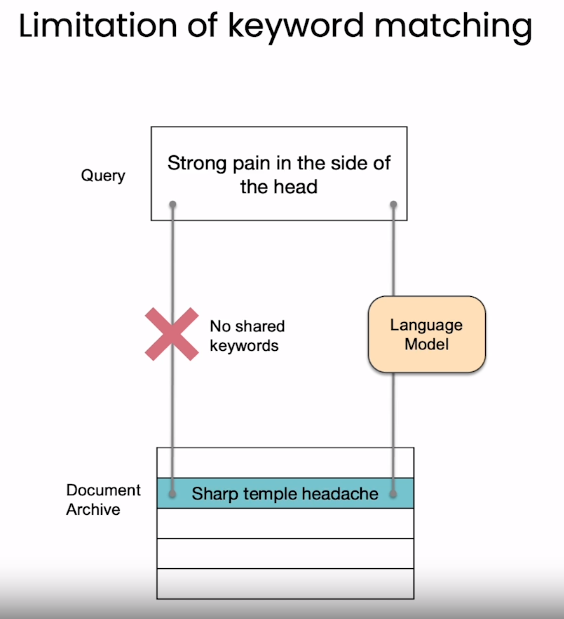

语言模型可以改进搜索的两个阶段，在接下来的课程中，我们将学习如何做到这一点。我们将看到语言模型如何通过嵌入（Embedding）来改进检索或第一阶段。
嵌入（Embedding）将是下一章的主题。然后我们将看一下重新排序（Reranking)是如何工作的，以及它如何改进第二阶段。在本课程的最后，我们将看一下大语言模型（LLM）如何根据之前的搜索步骤生成响应。